---
format: 
  html:
    toc: true
    page-layout: full
execute:
    warning: false
    echo: true
    eval: true
---

# Predictors Comparison Across Seasons

In this notebook, we will evaluate the power of each of our predictors in predicting COPD and assess their effectiveness for different seasons. Specifically, we will run Random Forest Regressions on all of our predictors, predictors after dimensionality reduction, using only sociobehavioral variables, and using only environmental variables. While there are some multicollinearities in the dataset, we proceed with this approach as Random Forests handle multicollinearity by averaging over multiple trees, reducing the risk of overfitting and still providing valuable insights into feature importance.

We will mainly draw on the following packages from sklearn in this section: 

- **metrics**, which includes `make_scorer`, `mean_squared_error`, `r2_score`, `mean_absolute_error`: Provides functions to evaluate the performance of the regression models, calculating error metrics and scoring metrics like R².

- **model_selection**, mainly `train_test_split`: Used to split the dataset into training and testing sets, ensuring the model is validated on unseen data.

- **ensemble**, mainly `RandomForestRegressor`: The core model used for regression, which builds multiple decision trees and combines their predictions to enhance accuracy.

- **model_selection**, mainly `cross_validate`: Allows cross-validation to assess the performance of the model across different subsets of the data, helping to ensure the model generalizes well.


In [114]:
#| code-fold: true

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, cross_val_predict
import tensorflow as tf
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

## The Random Forest Model



A Random Forest model is a versatile machine learning algorithm commonly used for regression analysis. It operates by constructing a multitude of decision trees during training and outputs the average of their predictions to provide robust and accurate results. Each tree in the forest is trained on a random subset of the data, with features also randomly sampled at each split, which helps reduce overfitting and ensures diversity among the trees. This ensemble approach improves model stability and accuracy by leveraging the collective predictions of multiple trees. Random Forest is particularly effective when dealing with datasets that have complex relationships, non-linear patterns, or a mix of categorical and continuous variables. It also provides insights into feature importance, allowing researchers to understand the relative contribution of each predictor in the model. Despite its strengths, Random Forest models can be computationally intensive and may require careful tuning of hyperparameters like the number of trees and maximum tree depth for optimal performance.

**Random Forest Regressor**

![](../assets/rf.jpg)

Since we will be running the machine learning model multiple times for each seaon's data, we defined some helper functions to streamline the process. The `split_and_scale_data` function prepares the data for Random Forest Regression by first splitting it into training and testing sets using `train_test_split` with stratification to maintain the target variable distribution. It then scales the features using StandardScaler to standardize the data, ensuring that all features contribute equally to the model. This step is crucial for consistent model performance, especially when features have varying scales (like ours).

In [2]:
#| code-fold: true

def split_and_scale_data(X, y, stratify_col, test_size=0.2, random_state=42):
   
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=stratify_col
    )
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler


The `train_and_evaluate_rf` function trains a Random Forest model using the RandomForestRegressor with a specified number of estimators. It fits the model to the training data and then makes predictions on the test set. The function calculates key performance metrics, including **Mean Squared Error (MSE), Root Mean Squared Error (RMSE), R-squared (R²), and Mean Absolute Error (MAE)**, to evaluate model accuracy. Additionally, it computes feature importances to identify which variables contribute most to the model's predictions, returning the predictions, evaluation metrics, and a sorted dataframe of feature importances.

In [3]:
#| code-fold: true

def train_and_evaluate_rf(X_train, X_test, y_train, y_test, feature_names, n_estimators=100, random_state=42):

    # Train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    predictions_rf = rf_model.predict(X_test)
    
    # Calculate metrics
    mse_rf = mean_squared_error(y_test, predictions_rf)
    rmse_rf = np.sqrt(mse_rf)
    r2_rf = r2_score(y_test, predictions_rf)
    mae_rf = mean_absolute_error(y_test, predictions_rf)

    # Compute feature importances
    feature_importances = rf_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    return {
        'predictions': predictions_rf,
        'rmse': rmse_rf,
        'r2': r2_rf,
        'importance_df': importance_df
    }


The `extract_results` function extracts key results from the output of a model evaluation. It retrieves the RMSE (Root Mean Squared Error) and R² (R-squared) metrics from the results, which provide insights into the model's accuracy. The function also extracts the top 5 most important features based on their feature importances, which help in understanding which variables have the greatest influence on the model's predictions. It returns both the performance metrics and the list of top features.

In [4]:
#| code-fold: true

def extract_results(results, method_name):
    
    # Extract metrics
    metrics = [results['rmse'], results['r2']]
    
    # Extract top 5 features
    top_features = results['importance_df']['Feature'].head(5).tolist()
    return metrics, top_features

In [5]:
#| echo: false

PA_Spring = pd.read_csv('../data/Intermediaries/PA_Spring.csv')
PA_Summer = pd.read_csv('../data/Intermediaries/PA_Summer.csv')
PA_Fall = pd.read_csv('../data/Intermediaries/PA_Fall.csv')
PA_Winter = pd.read_csv('../data/Intermediaries/PA_Winter.csv')

## Fitting the Model

The above functions will be applied separately using four different sets of predictors: all variables, only environmental variables, only sociobehavioral variables, and variables after dimensionality reduction. This approach allows us to assess the predictive power of each group of variables and determine their effectiveness in predicting COPD for each season. For each season, four models will be trained and evaluated. 

In [6]:
#| code-fold: true

# using all variables 
stratify_col = PA_Spring['CountyName']
X_Spring_All = PA_Spring[['Smoking', 'Drinking', 'Short_Sleep', 'Physical_Activity', 'neighbor_avg_density', 
                    'minority', 'aging', 'disability', 'forest_total', 'wetland_total', 'Hdensity_total',
                    'Ldensity_total', 'grasses_total', 'water_total', 'forest_pct',  'Hdensity_pct', 
                    'evi_spring','lst_spring', 'ndvi_spring', 'savi_spring']]
y_Spring = PA_Spring[['spring_count']]
X_train_scaled, X_test_scaled, y_train, y_test_sp, scaler = split_and_scale_data(X_Spring_All, y_Spring, stratify_col)
spring_result = train_and_evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test_sp, X_Spring_All.columns)                   

In [7]:
#| code-fold: true

# using all variables after dimensionality reduction
X_Spring_BIC = PA_Spring[['Smoking', 'Drinking', 'Short_Sleep', 'Physical_Activity', 'minority', 'aging', 'disability', 'forest_total', 'Ldensity_total', 'grasses_total', 'forest_pct', 'lst_spring']]
X_train_scaled, X_test_scaled, y_train, y_test_sp, scaler = split_and_scale_data(X_Spring_BIC, y_Spring, stratify_col)
spring_result_BIC = train_and_evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test_sp, X_Spring_BIC.columns)

In [8]:
#| code-fold: true

# using all environmental predictors
X_Spring_Env = PA_Spring[['forest_total', 'wetland_total', 'Hdensity_total',
                    'Ldensity_total', 'grasses_total', 'water_total', 'forest_pct',  'Hdensity_pct', 
                    'evi_spring','lst_spring', 'ndvi_spring', 'savi_spring']]
X_train_scaled, X_test_scaled, y_train, y_test_sp, scaler = split_and_scale_data(X_Spring_Env, y_Spring, stratify_col)
spring_result_env = train_and_evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test_sp, X_Spring_Env.columns)

In [9]:
#| code-fold: true

# using all socio-behavioral predictors
X_Spring_Sol = PA_Spring[['Smoking', 'Drinking', 'Short_Sleep', 'Physical_Activity', 'neighbor_avg_density', 
                      'minority', 'aging', 'disability']]
X_train_scaled, X_test_scaled, y_train, y_test_sp, scaler = split_and_scale_data(X_Spring_Sol, y_Spring, stratify_col)
spring_result_sol = train_and_evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test_sp, X_Spring_Sol.columns)

In [13]:
#| echo: false

stratify_col = PA_Summer['CountyName']
X_Summer_All = PA_Summer[['Smoking', 'Drinking', 'Short_Sleep', 'Physical_Activity', 'neighbor_avg_density', 
                    'minority', 'aging', 'disability', 'forest_total', 'wetland_total', 'Hdensity_total',
                    'Ldensity_total', 'grasses_total', 'water_total', 'forest_pct',  'Hdensity_pct', 
                    'evi_summer','lst_summer', 'ndvi_summer', 'savi_summer']]
y_Summer = PA_Summer[['summer_count']]
X_train_scaled, X_test_scaled, y_train, y_test_su, scaler = split_and_scale_data(X_Summer_All, y_Summer, stratify_col)
summer_result = train_and_evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test_su, X_Summer_All.columns)                   

In [14]:
#| echo: false

X_Summer_BIC = PA_Summer[['Smoking', 'Drinking', 'Short_Sleep', 'Physical_Activity', 'minority', 'aging', 'disability', 'forest_total', 'Ldensity_total', 'grasses_total', 'forest_pct', 'lst_summer']]
X_train_scaled, X_test_scaled, y_train, y_test_su, scaler = split_and_scale_data(X_Summer_BIC, y_Summer, stratify_col)
summer_result_BIC = train_and_evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test_su, X_Summer_BIC.columns)

In [15]:
#| echo: false

X_Summer_Env = PA_Summer[['forest_total', 'wetland_total', 'Hdensity_total',
                    'Ldensity_total', 'grasses_total', 'water_total', 'forest_pct',  'Hdensity_pct', 
                    'evi_summer','lst_summer', 'ndvi_summer', 'savi_summer']]
X_train_scaled, X_test_scaled, y_train, y_test_su, scaler = split_and_scale_data(X_Summer_Env, y_Summer, stratify_col)
summer_result_env = train_and_evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test_su, X_Summer_Env.columns)

In [16]:
#| echo: false

X_Summer_Sol = PA_Summer[['Smoking', 'Drinking', 'Short_Sleep', 'Physical_Activity', 'neighbor_avg_density', 
                      'minority', 'aging', 'disability']]
X_train_scaled, X_test_scaled, y_train, y_test_su, scaler = split_and_scale_data(X_Summer_Sol, y_Summer, stratify_col)
summer_result_sol = train_and_evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test_su, X_Summer_Sol.columns)

In [17]:
#| echo: false

stratify_col = PA_Fall['CountyName']
X_Fall_All = PA_Fall[['Smoking', 'Drinking', 'Short_Sleep', 'Physical_Activity', 'neighbor_avg_density', 
                    'minority', 'aging', 'disability', 'forest_total', 'wetland_total', 'Hdensity_total',
                    'Ldensity_total', 'grasses_total', 'water_total', 'forest_pct',  'Hdensity_pct', 
                    'evi_fall','lst_fall', 'ndvi_fall', 'savi_fall']]
y_Fall = PA_Fall[['fall_count']]
X_train_scaled, X_test_scaled, y_train, y_test_fa, scaler = split_and_scale_data(X_Fall_All, y_Fall, stratify_col)
fall_result = train_and_evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test_fa, X_Fall_All.columns)

In [18]:
#| echo: false

X_Fall_BIC = PA_Fall[['Smoking', 'Drinking', 'Short_Sleep', 'Physical_Activity', 'minority', 'aging', 'disability', 'forest_total', 'Ldensity_total', 'grasses_total', 'forest_pct', 'lst_fall']]
X_train_scaled, X_test_scaled, y_train, y_test_fa, scaler = split_and_scale_data(X_Fall_BIC, y_Fall, stratify_col)
fall_result_BIC = train_and_evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test_fa, X_Fall_BIC.columns)

In [19]:
#| echo: false

X_Fall_Env = PA_Fall[['forest_total', 'wetland_total', 'Hdensity_total',
                    'Ldensity_total', 'grasses_total', 'water_total', 'forest_pct',  'Hdensity_pct', 
                    'evi_fall','lst_fall', 'ndvi_fall', 'savi_fall']]
X_train_scaled, X_test_scaled, y_train, y_test_fa, scaler = split_and_scale_data(X_Fall_Env, y_Fall, stratify_col)
fall_result_env = train_and_evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test_fa, X_Fall_Env.columns)

In [20]:
#| echo: false

X_Fall_Sol = PA_Fall[['Smoking', 'Drinking', 'Short_Sleep', 'Physical_Activity', 'neighbor_avg_density', 
                      'minority', 'aging', 'disability']]
X_train_scaled, X_test_scaled, y_train, y_test_fa, scaler = split_and_scale_data(X_Fall_Sol, y_Fall, stratify_col)
fall_result_sol = train_and_evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test_fa, X_Fall_Sol.columns)

In [21]:
#| echo: false
stratify_col = PA_Winter['CountyName']
X_Winter_All = PA_Winter[['Smoking', 'Drinking', 'Short_Sleep', 'Physical_Activity', 'neighbor_avg_density', 
                    'minority', 'aging', 'disability', 'forest_total', 'wetland_total', 'Hdensity_total',
                    'Ldensity_total', 'grasses_total', 'water_total', 'forest_pct',  'Hdensity_pct', 
                    'evi_winter','lst_winter', 'ndvi_winter', 'savi_winter']]
y_Winter = PA_Winter[['winter_count']]
X_train_scaled, X_test_scaled, y_train, y_test_wi, scaler = split_and_scale_data(X_Winter_All, y_Winter, stratify_col)
winter_result = train_and_evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test_wi, X_Winter_All.columns)

In [22]:
#| echo: false
X_Winter_BIC = PA_Winter[['Smoking', 'Drinking', 'Short_Sleep', 'Physical_Activity', 'minority', 'aging', 'disability', 'forest_total', 'Ldensity_total', 'grasses_total', 'forest_pct', 'lst_winter']]
X_train_scaled, X_test_scaled, y_train, y_test_wi, scaler = split_and_scale_data(X_Winter_BIC, y_Winter, stratify_col)
winter_result_BIC = train_and_evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test_wi, X_Winter_BIC.columns)

In [23]:
#| echo: false
X_Winter_Env = PA_Winter[['forest_total', 'wetland_total', 'Hdensity_total',
                    'Ldensity_total', 'grasses_total', 'water_total', 'forest_pct',  'Hdensity_pct', 
                    'evi_winter','lst_winter', 'ndvi_winter', 'savi_winter']]
X_train_scaled, X_test_scaled, y_train, y_test_wi, scaler = split_and_scale_data(X_Winter_Env, y_Winter, stratify_col)
winter_result_env = train_and_evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test_wi, X_Winter_Env.columns)

In [24]:
#| echo: false
X_Winter_Sol = PA_Winter[['Smoking', 'Drinking', 'Short_Sleep', 'Physical_Activity', 'neighbor_avg_density', 
                      'minority', 'aging', 'disability']]
X_train_scaled, X_test_scaled, y_train, y_test_wi, scaler = split_and_scale_data(X_Winter_Sol, y_Winter, stratify_col)
winter_result_sol = train_and_evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test_wi, X_Winter_Sol.columns)

## Goodness of Fit Measure

After running the model 16 times (4 models for each of the 4 predictor sets across the seasons), we obtain 16 result outputs. From each model, we extract the R² and RMSE metrics as well as the top five predictors contributing the most to the predictions. The RMSE (Root Mean Squared Error) represents the average magnitude of prediction error, where lower values indicate better model performance. The R² (coefficient of determination) reflects the proportion of variance in the target variable that is explained by the predictors, with values closer to 1 indicating a better fit.

Again, the purpose of this analysis is to evaluate the predictive strength of different sets of variables and identify the most impactful predictors for COPD across seasons. All results are compiled into a unified table for easier interpretation, and the output is displayed below.

In [87]:
#| code-fold: true

methods = ['sp_all', 'sp_bic', 'sp_env', 'sp_sol',
           'su_all', 'su_bic', 'su_env', 'su_sol', 
           'fa_all', 'fa_bic', 'fa_env', 'fa_sol',
           'wi_all', 'wi_bic', 'wi_env', 'wi_sol']  
results = [spring_result, spring_result_BIC, spring_result_env, spring_result_sol, 
           summer_result, summer_result_BIC, summer_result_env, summer_result_sol,
           fall_result, fall_result_BIC, fall_result_env, fall_result_sol,
           winter_result, winter_result_BIC, winter_result_env, winter_result_sol
           ]

metrics_data = {}
top_features_data = {}

for method, result in zip(methods, results):
    metrics, top_features = extract_results(result, method)
    metrics_data[method] = metrics
    top_features_data[method] = top_features

compare_metrics = pd.DataFrame(metrics_data, index=['RMSE', 'R2'])
compare_top_features = pd.DataFrame(top_features_data, index=[f'Feature {i+1}' for i in range(5)])

### Comparing the R2 Across 16 Model

**Table Showing R2 Score By Model and Season**

In [ ]:
#| echo: false
r2_df = compare_metrics.loc['R2'].reset_index()
r2_df[['Season', 'Model']] = r2_df['index'].str.extract(r'(sp|su|fa|wi)_(.*)')
r2_df = r2_df.drop(columns='index')
season_map = {'sp': 'Spring', 'su': 'Summer', 'fa': 'Fall', 'wi': 'Winter'}
r2_df['Season'] = r2_df['Season'].map(season_map)
pivot_r2 = r2_df.pivot(index='Season', columns='Model', values='R2')
pivot_r2_by_model = r2_df.pivot(index='Model', columns='Season', values='R2')

In [61]:
#| echo: false
pivot_r2

Model,all,bic,env,sol
Season,,,,
Fall,0.561480,0.504986,0.385853,0.269291
Spring,0.561549,0.527482,0.431229,0.268616
Summer,0.560847,0.500596,0.386002,0.269822
Winter,0.552514,0.490316,0.372439,0.270203


The analysis of R² values reveals several important insights about the performance of our models in predicting COPD across different seasons and predictor subsets. First, models that include all predictor variables consistently achieve the highest R² scores for every season. This indicates that combining environmental and sociobehavioral factors provides the most comprehensive understanding of the variability in COPD, as these variables likely capture a wide range of relevant influences.

When dimensionality reduction is applied, the R² values decrease, suggesting some loss of information. However, even with dimensionality reduction, the models explain more than half of the variability in COPD outcomes. This implies that while reducing the number of predictors sacrifices some predictive power, the retained variables are still meaningful contributors to the model. Comparing the models that use only environmental or sociobehavioral variables, the R² values are higher for the environmental variable models across all seasons. 

Seasonal differences emerge as a key aspect of the analysis. The spring models achieve the highest R² values when all predictors are used and when only environmental variables are included, but they exhibit the lowest R² when using only sociobehavioral variables. This trend is followed by the summer and fall models, which also show relatively strong R² values under similar conditions. In contrast, the winter models have the highest R² values when using only sociobehavioral variables, indicating a distinct seasonal dynamic.

Given that the primary difference between seasonal models lies in the local environmental vegetation indices, these results suggest that **winter environmental factors may contribute less variability to COPD outcomes compared to sociobehavioral variables during this season**. This could reflect reduced vegetation activity and lower pollen levels in winter, leading to less influence of environmental predictors. Conversely, the higher R² values for spring models with environmental predictors likely reflect the **strong impact of vegetation indices and related environmental conditions, such as increased pollen levels and changing air quality, which are more pronounced during spring** compared to winter


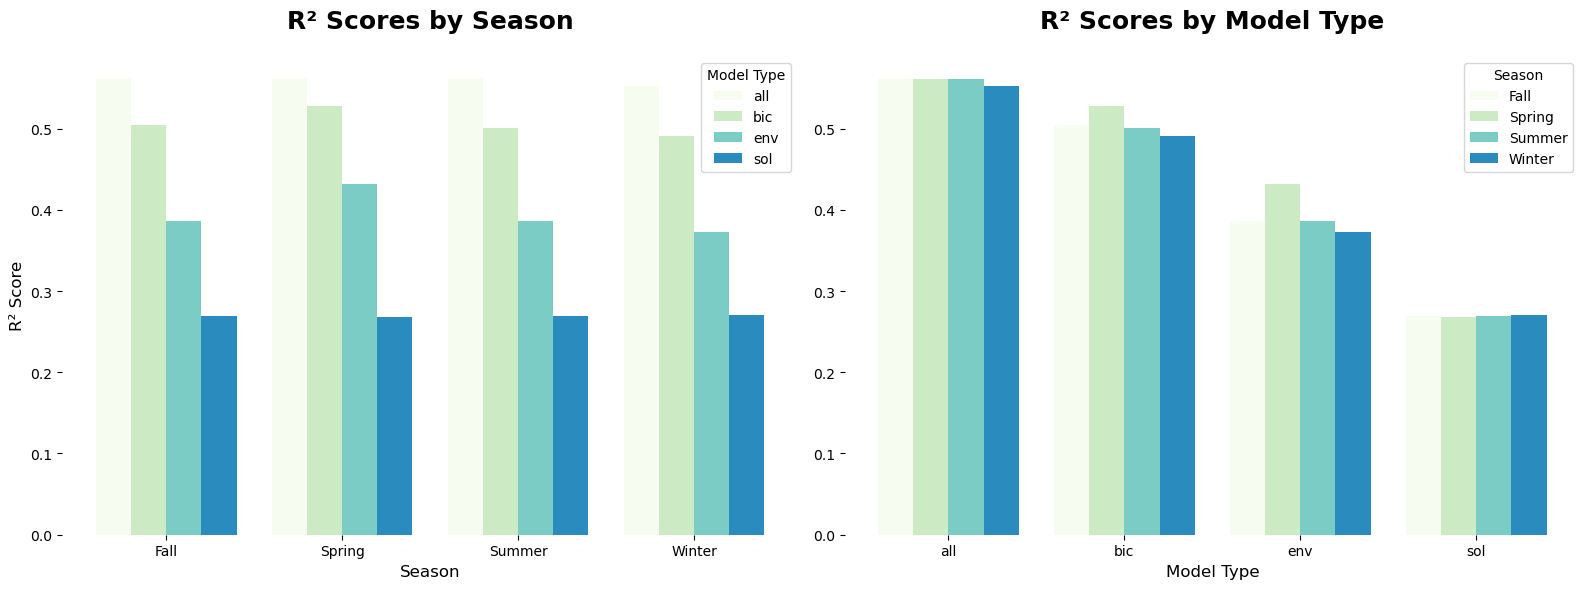

In [103]:
#| echo: false
from matplotlib.cm import get_cmap

cmap = get_cmap('GnBu')
colors = [cmap(i / 4) for i in range(4)]  # 4 colors for the models or seasons

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=False)

# --- First plot: Grouped by season ---
bar_width = 0.2
x = np.arange(len(seasons)) 

for i, model in enumerate(models):
    axes[0].bar(x + i * bar_width, pivot_r2[model], bar_width, label=model, color=colors[i])

axes[0].set_xlabel('Season', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Scores by Season', fontsize=18, pad=20, fontweight='bold')
axes[0].set_xticks(x + 1.5 * bar_width)
axes[0].set_xticklabels(seasons)
axes[0].legend(title='Model Type')
axes[0].spines[:].set_visible(False) 

# --- Second plot: Grouped by model type ---
x = np.arange(len(models))

for i, season in enumerate(seasons):
    axes[1].bar(x + i * bar_width, pivot_r2_by_model[season], bar_width, label=season, color=colors[i])

axes[1].set_xlabel('Model Type', fontsize=12)
axes[1].set_title('R² Scores by Model Type', fontsize=18, pad=20, fontweight='bold')
axes[1].set_xticks(x + 1.5 * bar_width)
axes[1].set_xticklabels(models)
axes[1].legend(title='Season')
axes[1].spines[:].set_visible(False) 

plt.tight_layout()
plt.show()

### Comparing the RMSE Across 16 Models

**Table Showing RMSE By Model and Season**

In [64]:
#| echo: false
rmse_df = compare_metrics.loc['RMSE'].reset_index()
rmse_df[['Season', 'Model']] = rmse_df['index'].str.extract(r'(sp|su|fa|wi)_(.*)')
rmse_df = rmse_df.drop(columns='index')
rmse_df['Season'] = rmse_df['Season'].map(season_map)
pivot_rmse = rmse_df.pivot(index='Season', columns='Model', values='RMSE')
pivot_rmse_by_model = rmse_df.pivot(index='Model', columns='Season', values='RMSE')

In [66]:
#| echo: false
pivot_rmse

Model,all,bic,env,sol
Season,,,,
Fall,20.206061,21.468205,23.912397,26.083081
Spring,22.224898,23.072179,25.313270,28.704642
Summer,15.974291,17.034905,18.888489,20.598157
Winter,26.535056,28.319169,31.423747,33.886842


Examining the RMSE results, the summer models consistently exhibit the lowest RMSE across all model types, while the winter models show the highest RMSE. Including all variables results in significantly lower RMSE values, reflecting better predictive accuracy. Conversely, dimensionality reduction slightly increases RMSE, and the highest RMSE values are observed when using only sociobehavioral variables.

These RMSE findings align with the R² results. Lower RMSE and higher R² values in the "all predictors" models indicate that the inclusion of both environmental and sociobehavioral variables leads to more accurate and explanatory models for predicting COPD. The slightly higher RMSE and lower R² values after dimensionality reduction suggest some loss of information, which reduces the model's predictive power but still maintains reasonable performance.

Seasonally, the lowest RMSE in summer models suggest that **summer conditions may lead to more predictable COPD outcomes, potentially due to less variability in environmental factors like vegetation indices or air quality during this time.** On the other hand, the higher RMSE in winter, coupled with relatively lower R² values for environmental models, points to a weaker relationship between winter environmental conditions and COPD. This reinforces the earlier observation that sociobehavioral variables play a more prominent role in winter, where environmental variability is less influential.

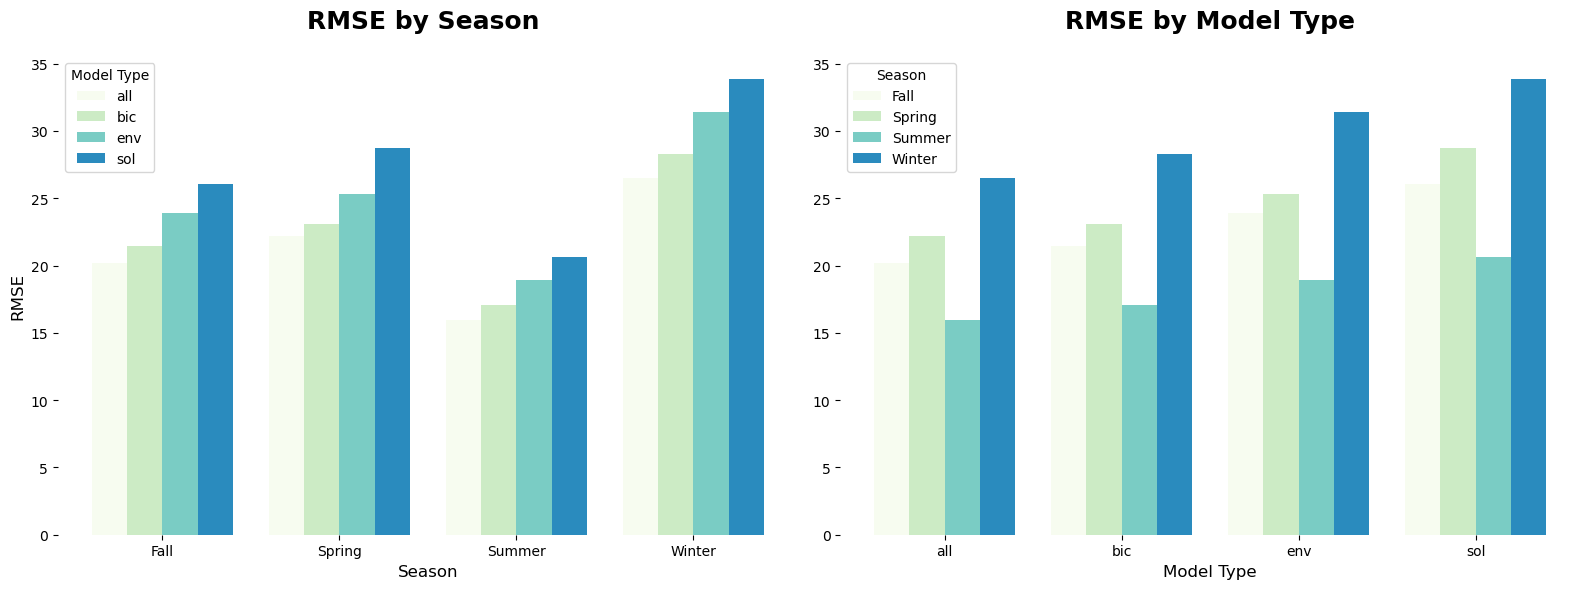

In [101]:
#| echo: false
from matplotlib.cm import get_cmap

cmap = get_cmap('GnBu')
colors = [cmap(i / 4) for i in range(4)]  # 4 colors for the models or seasons

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=False)

# --- First plot: Grouped by season ---
bar_width = 0.2
x = np.arange(len(seasons)) 

for i, model in enumerate(models):
    axes[0].bar(x + i * bar_width, pivot_rmse[model], bar_width, label=model, color=colors[i])

axes[0].set_xlabel('Season', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('RMSE by Season ', fontsize=18, pad=20, fontweight='bold')
axes[0].set_xticks(x + 1.5 * bar_width)
axes[0].set_xticklabels(seasons)
axes[0].legend(title='Model Type')
axes[0].spines[:].set_visible(False) 

# --- Second plot: Grouped by model type ---
x = np.arange(len(models))

for i, season in enumerate(seasons):
    axes[1].bar(x + i * bar_width, pivot_rmse_by_model[season], bar_width, label=season, color=colors[i])

axes[1].set_xlabel('Model Type', fontsize=12)
axes[1].set_title('RMSE by Model Type', fontsize=18, pad=20, fontweight='bold')
axes[1].set_xticks(x + 1.5 * bar_width)
axes[1].set_xticklabels(models)
axes[1].legend(title='Season')
axes[1].spines[:].set_visible(False) 

plt.tight_layout()
plt.show()

### Compare Predictors with Highest Contribution

In models that include all predictor variables, **development density** stands out as the most significant contributor, followed closely by **physical activity** and **neighborhood tobacco retail density**. **Smoking behaviors** also play a role but come after the previous factors. These results indicate that population and urban infrastructure characteristics—such as density—along with lifestyle factors like physical activity and smoking, are crucial in explaining the variability in the models. This aligns with the notion that urban environments and behavioral factors are closely tied to the outcomes being modeled, such as health-related outcomes.

In [77]:
#| echo: false
compare_top_features[['sp_all', 'su_all', 'fa_all', 'wi_all']]

,sp_all,su_all,fa_all,wi_all
Feature 1,Hdensity_total,Hdensity_total,Hdensity_total,Hdensity_total
Feature 2,Ldensity_total,Ldensity_total,Ldensity_total,Ldensity_total
Feature 3,Physical_Activity,Physical_Activity,Physical_Activity,Physical_Activity
Feature 4,neighbor_avg_density,neighbor_avg_density,neighbor_avg_density,neighbor_avg_density
Feature 5,Smoking,Smoking,Smoking,Smoking


When we perform dimensionality reduction, the results shift slightly, but core contributors remain consistent. **Density and physical activity** continue to be among the most significant predictors, underscoring their consistent importance across various model configurations. However, other predictors such as **land surface temperature (LST)** by season and **smoking behavior** start to show a more prominent role. This shift indicates that once we reduce the number of variables, the remaining predictors capture more specific, localized aspects like seasonal temperature changes and personal health behaviors (e.g., smoking), which become increasingly important.

In [78]:
#| echo: false
compare_top_features[['sp_bic', 'su_bic', 'fa_bic', 'wi_bic']]

,sp_bic,su_bic,fa_bic,wi_bic
Feature 1,Ldensity_total,Ldensity_total,Ldensity_total,Ldensity_total
Feature 2,Physical_Activity,Physical_Activity,Physical_Activity,Physical_Activity
Feature 3,lst_spring,lst_summer,lst_fall,forest_total
Feature 4,forest_total,Smoking,Smoking,Smoking
Feature 5,Smoking,minority,forest_total,minority


In models that only include social behavioral variables, it is not surprising to see that physical activity emerges as the top contributor.

In [79]:
#| echo: false
compare_top_features[['sp_sol', 'su_sol', 'fa_sol', 'wi_sol']]

,sp_sol,su_sol,fa_sol,wi_sol
Feature 1,Physical_Activity,Physical_Activity,Physical_Activity,Physical_Activity
Feature 2,neighbor_avg_density,neighbor_avg_density,neighbor_avg_density,neighbor_avg_density
Feature 3,disability,disability,disability,disability
Feature 4,aging,aging,aging,aging
Feature 5,Smoking,Smoking,Smoking,Smoking


Turning to environmental predictors, we observe that **development density**, **surface temperature**, and N**DVI (Normalized Difference Vegetation Index)** emerge as the most important. These factors are indicative of the environmental characteristics that influence health outcomes. However, seasonal differences emerge when we look specifically at the winter models. In winter, both vegetation indices and temperature seem to have less influence compared to the other seasons. This may be due to reduced vegetation activity and temperature fluctuations in winter, making these factors less relevant to the outcome in colder months.

In [80]:
#| echo: false
compare_top_features[['sp_env', 'su_env', 'fa_env', 'wi_env']]

,sp_env,su_env,fa_env,wi_env
Feature 1,Hdensity_total,Hdensity_total,Hdensity_total,Hdensity_total
Feature 2,Ldensity_total,Ldensity_total,Ldensity_total,Ldensity_total
Feature 3,lst_spring,ndvi_summer,Hdensity_pct,Hdensity_pct
Feature 4,Hdensity_pct,lst_summer,lst_fall,lst_winter
Feature 5,ndvi_spring,Hdensity_pct,ndvi_fall,ndvi_winter


By examining these results together, we see how different types of predictors—social behavioral versus environmental—interact with seasonal changes and dimensionality reduction. The consistency of physical activity and development density top predictors across models highlights their importance as a fundamental health-related factor, irrespective of seasonal variations or environmental conditions. Conversely, environmental factors such as temperature and vegetation indices appear to be more sensitive to seasonal changes, with winter showing a distinct reduction in their relevance.

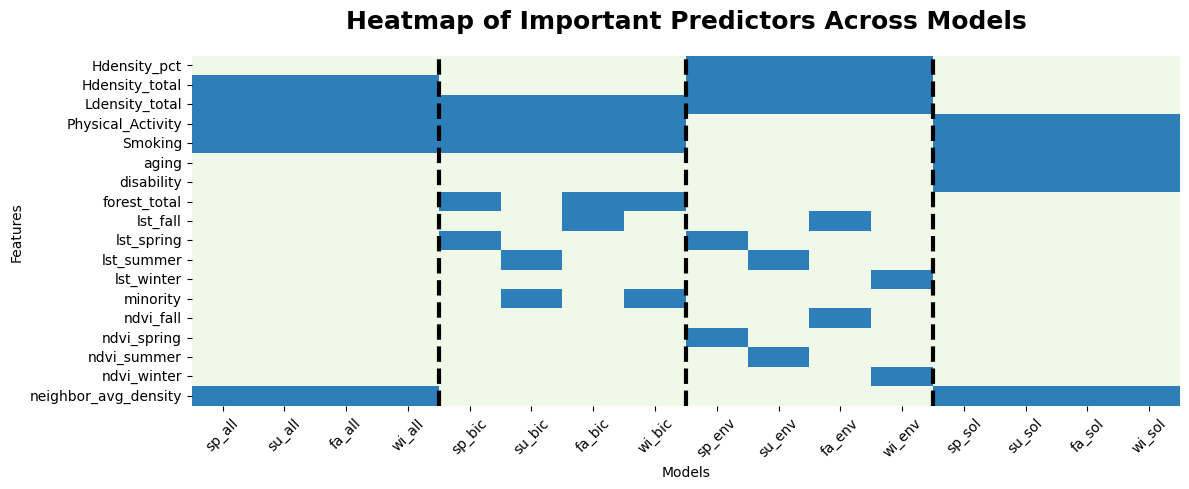

In [113]:
#| echo: false
column_order = ['sp_all', 'su_all', 'fa_all', 'wi_all', 
                'sp_bic', 'su_bic', 'fa_bic', 'wi_bic',  
                'sp_env', 'su_env', 'fa_env', 'wi_env', 
                'sp_sol', 'su_sol', 'fa_sol', 'wi_sol']  

compare_top_features = compare_top_features[column_order]

heatmap_data = compare_top_features.apply(compare_top_features.value_counts, axis=0).fillna(0)

custom_palette = sns.color_palette(["#f0f9e8", "#2c7fb8"])  

plt.figure(figsize=(12, 5))
ax = sns.heatmap(heatmap_data, annot=False, cmap=custom_palette, cbar=False, linewidths=0)

group_boundaries = [4.5, 8.5, 12.5] 

for boundary in group_boundaries:
    ax.axvline(x=boundary - 0.5, color='black', linestyle='--', linewidth=3) 

# Title and labels
plt.title("Heatmap of Important Predictors Across Models", fontsize=18, pad=20, fontweight='bold')
plt.ylabel("Features")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


## Understanding Prediction Error

In this section, 

look at a series of map showing that using the entire dataset, where is it underprdicting, and where is it over-predicting? with 5 fold cross validations, still using the random forest model


for bic spring, fall, autumn, and winter after dimensionality reduction
we will map the residuals 

### Predicted VS. Actual

In [124]:
#| code-fold: true

def train_and_evaluate_rf_with_cv_predictions(X, y, n_estimators=100, random_state=42, cv=5):

    # Define the model
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)

    # Define custom scorers
    scoring = {
        'mse': make_scorer(mean_squared_error, greater_is_better=False),
        'r2': make_scorer(r2_score)
    }

    # Perform cross-validation to calculate metrics
    cv_results = cross_validate(rf_model, X, y, scoring=scoring, cv=cv, return_train_score=False)

    # Perform cross-validation to get predictions
    predictions = cross_val_predict(rf_model, X, y, cv=cv)

    results = {
        'mean_rmse': np.sqrt(-np.mean(cv_results['test_mse'])),  # Convert negative MSE to positive RMSE
        'mean_r2': np.mean(cv_results['test_r2']),
        'predictions': predictions  # Cross-validated predictions for the entire dataset
    }
    
    return results


When there is a pattern in the residual plot, such as a positive linear relationship (or any other discernible trend), it generally indicates that the model is not capturing some aspect of the data properly. This suggests that the model is misspecified or that there are underlying relationships between the predictors and the target variable that the model is failing to capture.

If you see a positive linear relationship (i.e., residuals increase as the actual values increase), it means that the model tends to under-predict for higher values of the target variable and over-predict for lower values.

In [126]:
#| echo: false

seasons_data = {
    "Spring": (X_Spring_BIC, y_Spring),
    "Summer": (X_Summer_BIC, y_Summer),
    "Fall": (X_Fall_BIC, y_Fall),
    "Winter": (X_Winter_BIC, y_Winter)
}

season_results = {}

for season, (X, y) in seasons_data.items():
    cv_results = train_and_evaluate_rf_with_cv_predictions(X, y)
    season_results[season] = {
        'predictions': np.array(cv_results['predictions']),
        'actual': y.values.flatten(),  # Convert to 1D array
        'mean_rmse': cv_results['mean_rmse'],
        'mean_r2': cv_results['mean_r2']
    }

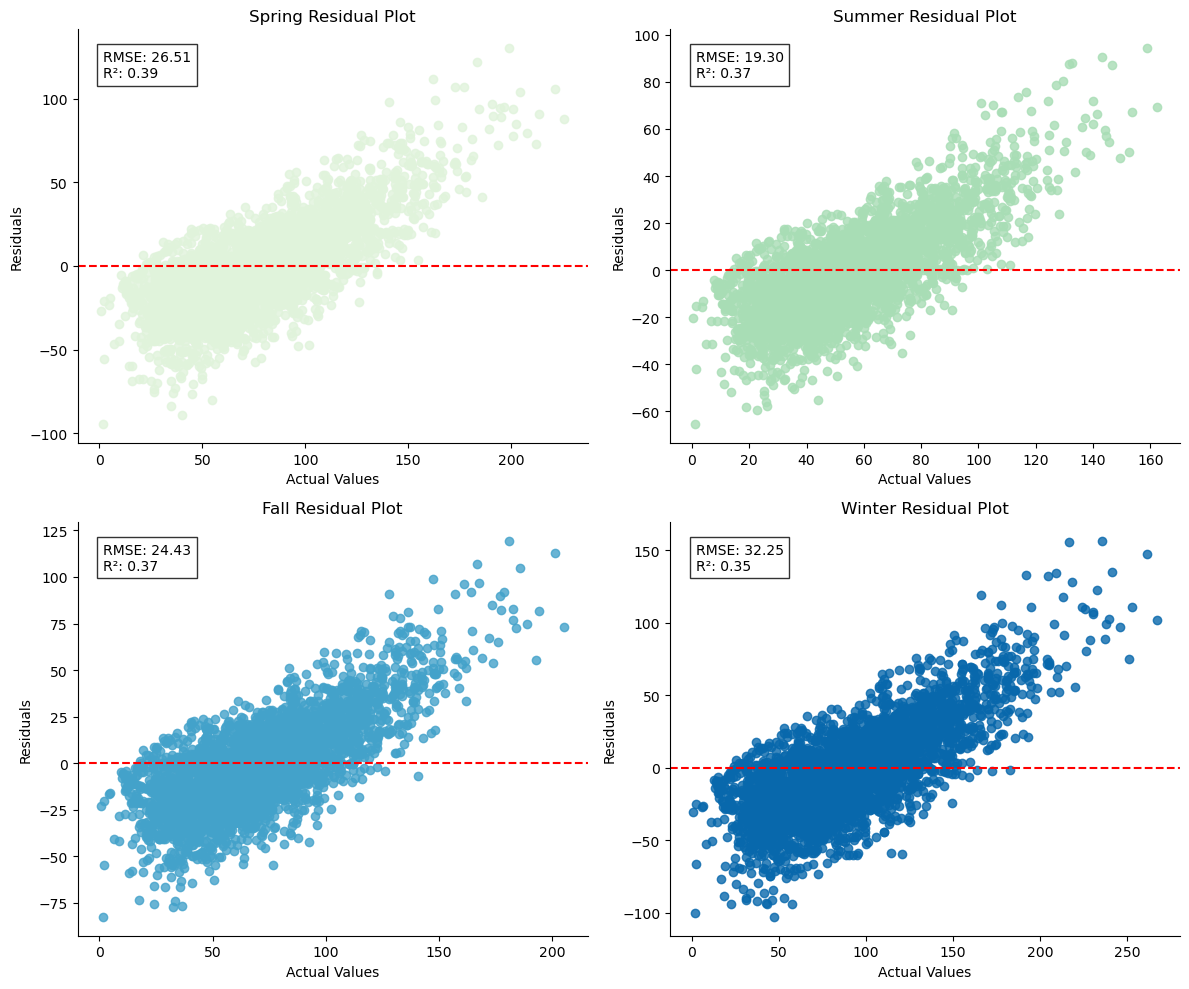

In [173]:
#| echo: false

colors = ['#e0f3db', '#a8ddb5', '#43a2ca', '#0868ac']  

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (season, results) in enumerate(season_results.items()):
    ax = axes[i]
    predictions = results['predictions']
    actual = results['actual']
    
    # Compute residuals
    residuals = actual - predictions
    
    # Residual plot: plot residuals on the y-axis, actual values on the x-axis
    ax.scatter(actual, residuals, alpha=0.8, c=colors[i], label=season)
    
    ax.axhline(0, color='red', linestyle='--', label='Zero Residual')

    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Residuals')
    ax.set_title(f'{season} Residual Plot')

    # Add RMSE and R² annotations
    rmse_text = f"RMSE: {results['mean_rmse']:.2f}"
    r2_text = f"R²: {results['mean_r2']:.2f}"
    ax.text(0.05, 0.95, f"{rmse_text}\n{r2_text}", transform=ax.transAxes,
            fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

handles, labels = axes[0].get_legend_handles_labels()
plt.tight_layout()
plt.show()


In [155]:
#| echo: false

season_dfs = {}

for season, result in season_results.items():
    season_df = pd.DataFrame({
        'Index': np.arange(len(result['predictions'])),
        'predictions': result['predictions'],
        'actual': result['actual'],
        'season': season
    })
    season_dfs[season] = season_df

PA_Spring['Index'] = PA_Spring.index
PA_Summer['Index'] = PA_Summer.index
PA_Fall['Index'] = PA_Fall.index
PA_Winter['Index'] = PA_Winter.index

PA_Spring_Res = PA_Spring.merge(season_dfs['Spring'], on='Index', how='left')
PA_Summer_Res = PA_Summer.merge(season_dfs['Summer'], on='Index', how='left')
PA_Fall_Res = PA_Fall.merge(season_dfs['Fall'], on='Index', how='left')
PA_Winter_Res = PA_Winter.merge(season_dfs['Winter'], on='Index', how='left')

In [157]:
#| echo: false

import pygris
tracts = pygris.tracts(state="42", year=2022)
tracts['GEOID'] = tracts['GEOID'].astype(str) 
PA_Spring_Res['GEOID'] = PA_Spring_Res['GEOID'].astype(str) 
PA_Summer_Res['GEOID'] = PA_Summer_Res['GEOID'].astype(str) 
PA_Fall_Res['GEOID'] = PA_Fall_Res['GEOID'].astype(str) 
PA_Winter_Res['GEOID'] = PA_Winter_Res['GEOID'].astype(str) 


PA_Spring_Res['residual'] = PA_Spring_Res['actual'] - PA_Spring_Res['predictions']
PA_Summer_Res['residual'] = PA_Summer_Res['actual'] - PA_Summer_Res['predictions']
PA_Fall_Res['residual'] = PA_Fall_Res['actual'] - PA_Fall_Res['predictions']
PA_Winter_Res['residual'] = PA_Winter_Res['actual'] - PA_Winter_Res['predictions']

PA_Spring_Res = PA_Spring_Res[['GEOID', 'residual']]
PA_Summer_Res = PA_Summer_Res[['GEOID', 'residual']]
PA_Fall_Res= PA_Fall_Res[['GEOID', 'residual']]
PA_Winter_Res = PA_Winter_Res[['GEOID', 'residual']]

PA_Spring_Res_geo = tracts.merge(PA_Spring_Res, on='GEOID', how='left')
PA_Summer_Res_geo = tracts.merge(PA_Summer_Res, on='GEOID', how='left')
PA_Fall_Res_geo = tracts.merge(PA_Fall_Res, on='GEOID', how='left')
PA_Winter_Res_geo = tracts.merge(PA_Winter_Res, on='GEOID', how='left')

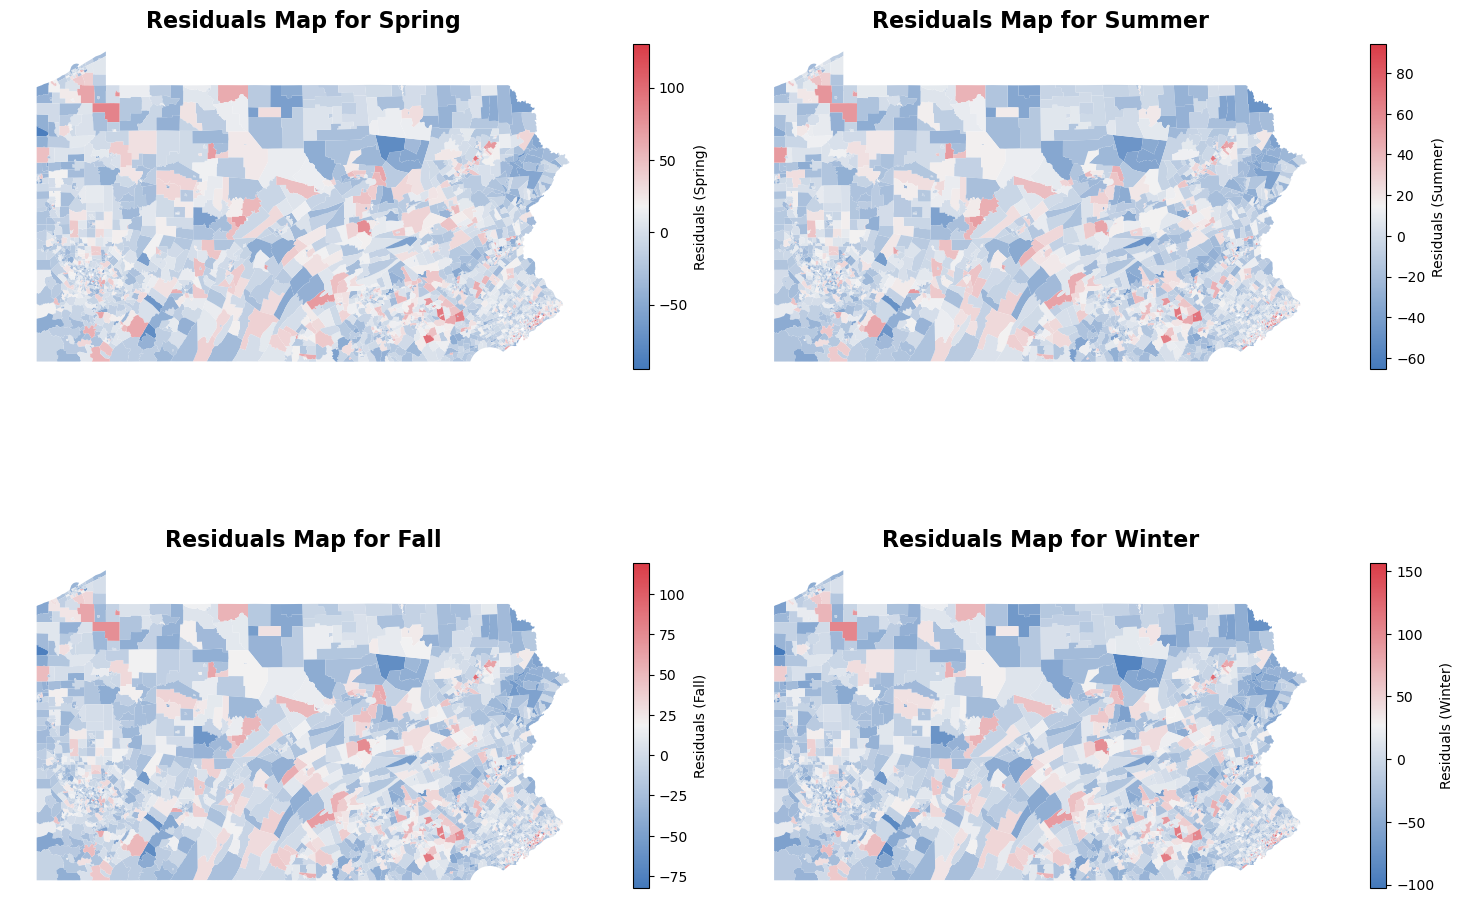

In [179]:
#| echo: false

cmap = sns.diverging_palette(250, 10, as_cmap=True)  

fig, axs = plt.subplots(2, 2, figsize=(15, 12))  

seasons = ['Spring', 'Summer', 'Fall', 'Winter']
geo_data = [PA_Spring_Res_geo, PA_Summer_Res_geo, PA_Fall_Res_geo, PA_Winter_Res_geo]

for ax, season, gdf in zip(axs.ravel(), seasons, geo_data):
    gdf.plot(column='residual', ax=ax, legend=True,
             legend_kwds={'label': f"Residuals ({season})", 'orientation': 'vertical', 'shrink': 0.5,},
             cmap=cmap)
    
    # Set title and remove borders for each subplot
    ax.set_axis_off()
    ax.set_title(f'Residuals Map for {season}', fontsize=16, fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

# Display the plot
plt.show()


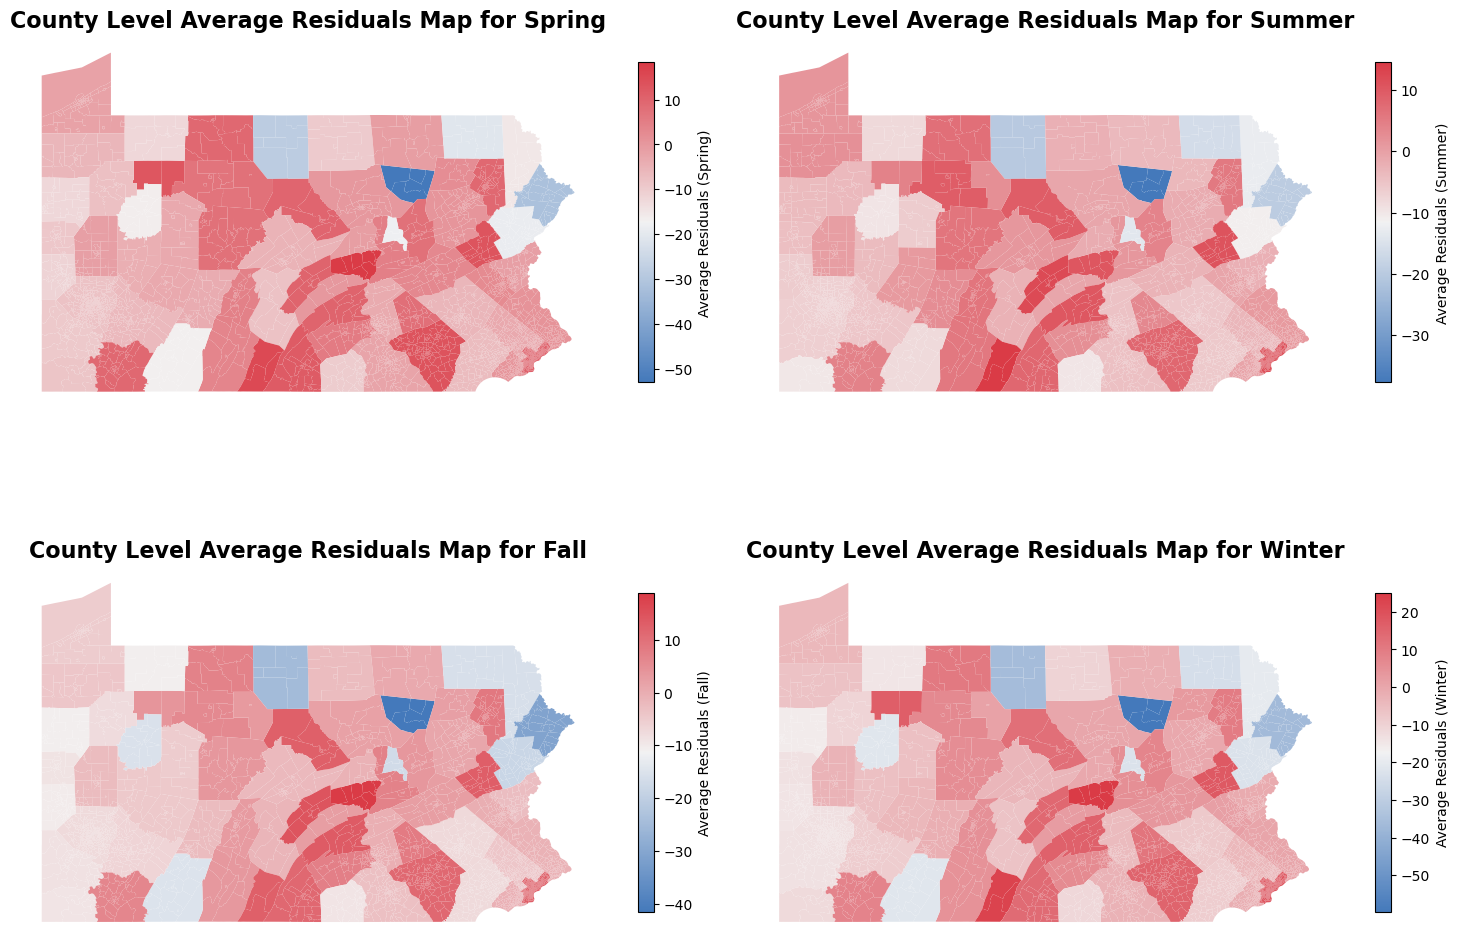

In [181]:
#| echo: false

counties = pygris.tracts(state="42", year=2022)
avg_residuals = {}
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
geo_data = [PA_Spring_Res_geo, PA_Summer_Res_geo, PA_Fall_Res_geo, PA_Winter_Res_geo]

for season, gdf in zip(seasons, geo_data):
    avg_residual = gdf.groupby('COUNTYFP')['residual'].mean().reset_index()
    avg_residual.rename(columns={'residual': f'avg_residual_{season}'}, inplace=True)
    avg_residuals[season] = avg_residual

# Merge average residuals with counties GeoDataFrame
joined_data = counties.copy()
for season in seasons:
    joined_data = joined_data.merge(avg_residuals[season], on='COUNTYFP', how='left')

    
    
cmap = sns.diverging_palette(250, 10, as_cmap=True) 
fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 grid, adjust size as needed

# Plot each season's average residuals map in a different subplot
for ax, season in zip(axs.ravel(), seasons):
    joined_data.plot(column=f'avg_residual_{season}', ax=ax, legend=True,
                     legend_kwds={'label': f"Average Residuals ({season})", 'orientation': 'vertical', 'shrink': 0.5,},
                     cmap=cmap)
    
    ax.set_axis_off()
    ax.set_title(f'County Level Average Residuals Map for {season}', fontsize=16, fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()
